In [134]:
import os
import sys
import itertools as itt

# File reading
from pathlib import Path
import czifile as czi
import tifffile as tiff

# Image preprocessing
import cv2
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects


# Calculations
from scipy import ndimage as ndi
import numpy as np

# Analysis
import astrobject as ao
import ccdb
import astromorpho as astro
import ucats

# Viewing
import napari
import matplotlib.pyplot as plt
%matplotlib inline

# Beauty
from tqdm.auto import tqdm

# Utils
from importlib import reload

In [135]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['image.cmap'] = 'gray'

In [244]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["black", "red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

# Параметры для запуска

In [172]:
if os.path.exists('/home/levtg/astro-morpho'):
    data_dir = '/home/levtg/astro-morpho/data/popov_morph/'
else:
    print("Dont know where to look for the data")

output_dir = '../output/'

filename = 'T5_.czi'

use_clahe = True
sigmas = 2**np.arange(0, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

# Set false to start from console
HANDY = True

# Set true to save output
OUT = False

# Считывание изображения

In [173]:
if HANDY:
    VERBOSE = True

In [174]:
datapath = Path(data_dir).joinpath(filename)
# datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/levtg/astro-morpho/data/popov_morph/T5_.czi')

In [175]:
tifname = Path(str(datapath)[:-3] + 'tif')

if tifname.exists():
    stack = tiff.imread(tifname)
else:
    czi.czi2tif(datapath, tiffile=tifname)
    stack = tiff.imread(tifname)[2]
stack.shape

(100, 512, 512)

In [176]:
stack.shape

(100, 512, 512)

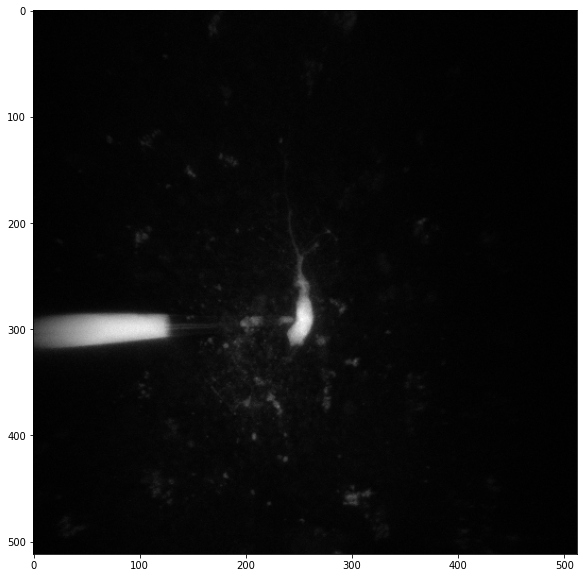

In [177]:
if VERBOSE:
#     w = napari.view_image(stack, ndisplay=3, opacity=0.5)
#     plt.imshow(w.screenshot())
#     w.close()
    imgplot = plt.imshow(np.sum(stack, axis=0))
    plt.show()

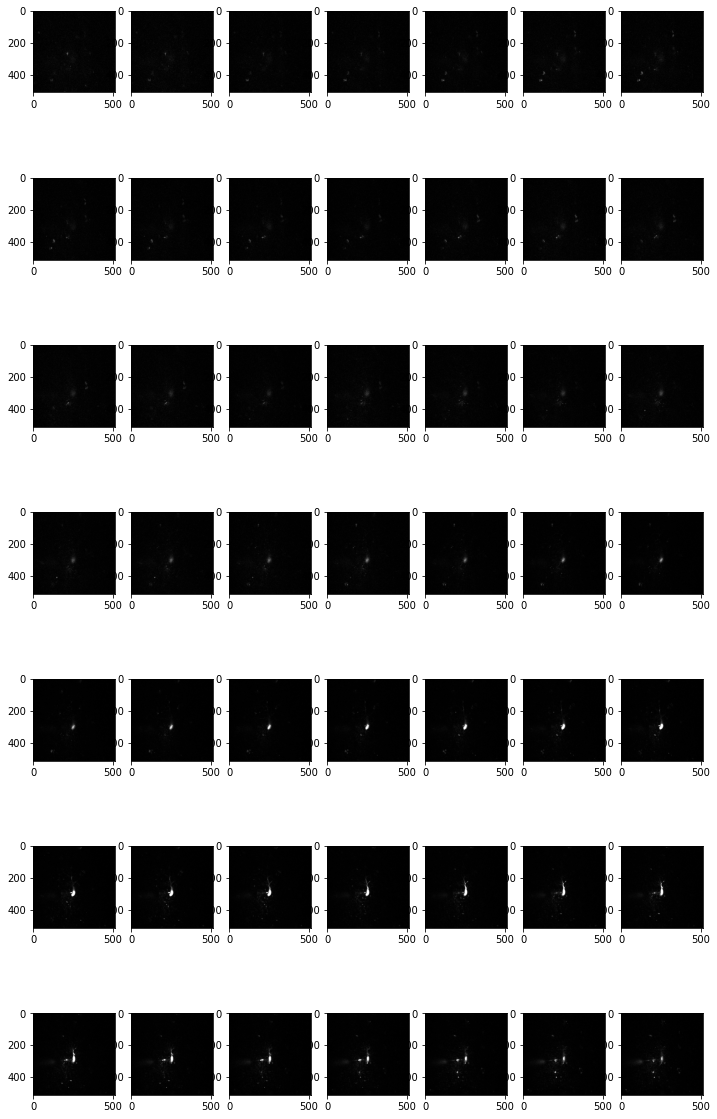

In [178]:
if VERBOSE:
    i = 14
    fig, axs = plt.subplots(7,7, figsize=(12,21))
    for ax, pic in zip(np.ravel(axs), stack[i:i+49]):
        ax.imshow(pic)

# Удаление пипетки

In [179]:
import pipette_segmentation as ps

In [180]:
image = stack

In [181]:
simple_mask = ps.make_simple_mask(image)
sato_mask = ps.make_sato_mask(image)
masks3 = ps.combine_masks(image, simple_mask, sato_mask)

vx = masks3.sum(axis=(1,2))
vx_sato = ps.st_roll(sato_mask).sum(axis=(1,2))

try:
    kink = ps.find_kink(vx)
except :
    #print(E)
    kink = len(vx)

masks3a = masks3.copy()
masks3a[kink:]=0
masks3a = ucats.masks.largest_region(masks3a)

  0%|          | 0/5 [00:00<?, ?it/s]

thresholds 0.028962081666597007 0.09847231690769845 0.1969446338153969
138


In [182]:
use_kink = True

In [183]:

masks3_final = masks3a if use_kink else masks3
masks3_final = np.moveaxis(masks3_final,0,2)

show_stack = (stack*(~(ndi.binary_dilation(masks3_final,iterations=3)))).astype(np.float64)

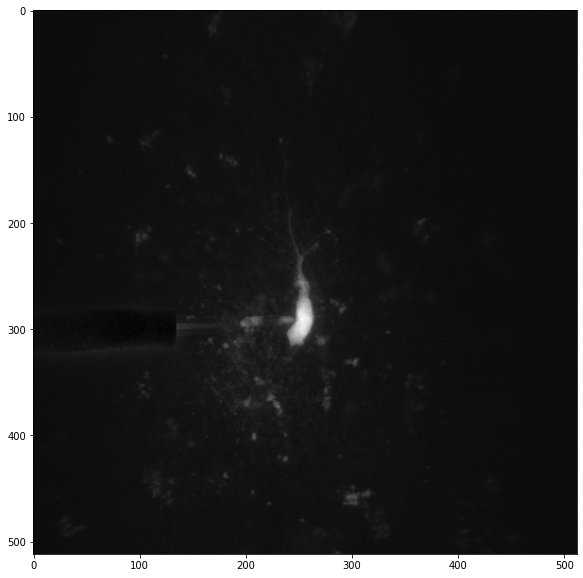

In [184]:
if VERBOSE:
    imgplot = plt.imshow(np.sum(show_stack, axis=0))
    plt.show()

# Предобработка изображения

In [185]:
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))

In [186]:
image = show_stack
stack_shape = image.shape
img_clahe = np.zeros(image.shape, np.float32)
for k, plane in enumerate(image):
    img_clahe[k] = clahe.apply(plane.astype('uint8'))

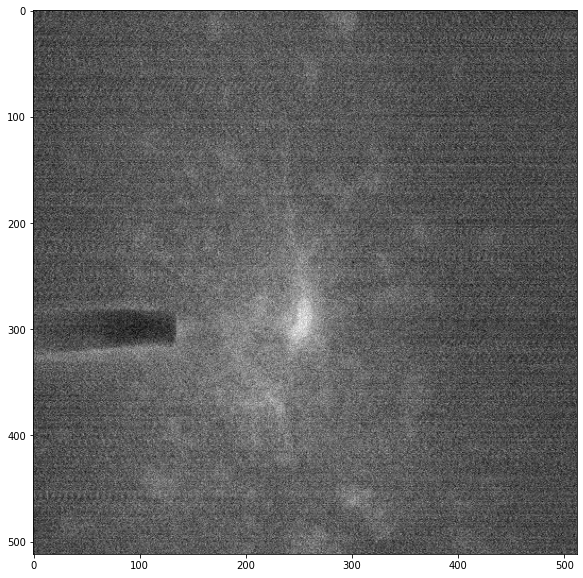

In [187]:
if VERBOSE:
    imgplot = plt.imshow(np.sum(img_clahe, axis=0))
    plt.show()

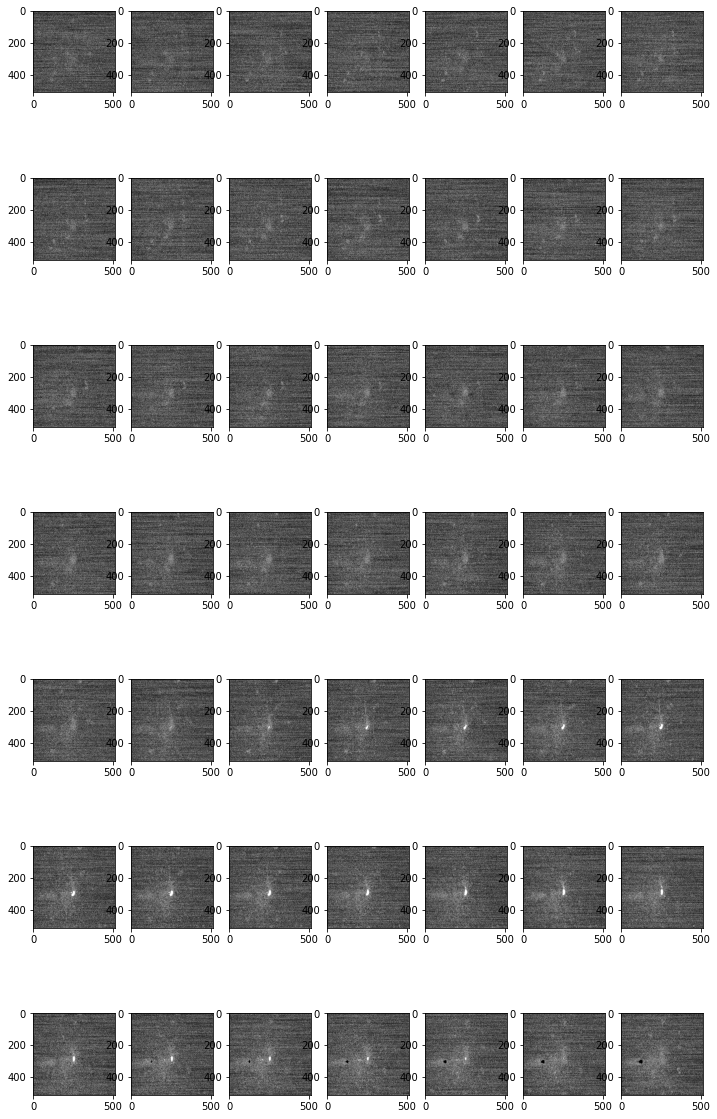

In [188]:
if VERBOSE:
    i = 14
    fig, axs = plt.subplots(7,7, figsize=(12,21))
    for ax, pic in zip(np.ravel(axs), img_clahe[i:i+49]):
        ax.imshow(pic)

In [189]:
img = img_clahe

In [226]:
np.sum(obj.soma_mask, axis=0).shape

(512, 512)

# Анализ

In [255]:
obj = ao.AstrObject(img)
print('Center')
obj.center_detection()
obj.center

Center


(53, 290, 249)

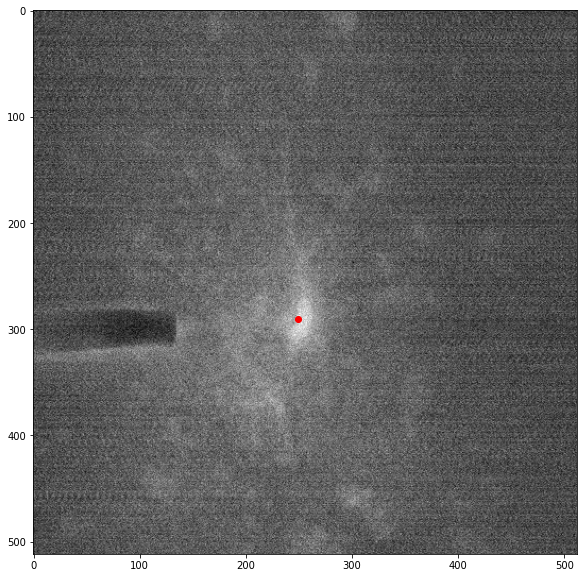

In [256]:
if VERBOSE:
    show_image = np.sum(img_clahe, axis=0)
    imgplot = plt.imshow(show_image)
    plt.scatter(*obj.center[:0:-1], c='r')
    plt.show()

In [257]:
print('Soma Mask')
%time obj.soma_segmentation(return_shell=True)

Soma Mask
Mask Expanding
Soma Shell
CPU times: user 3.17 s, sys: 34.9 ms, total: 3.21 s
Wall time: 3.21 s


In [258]:
obj.soma_mask.shape

(100, 512, 512)

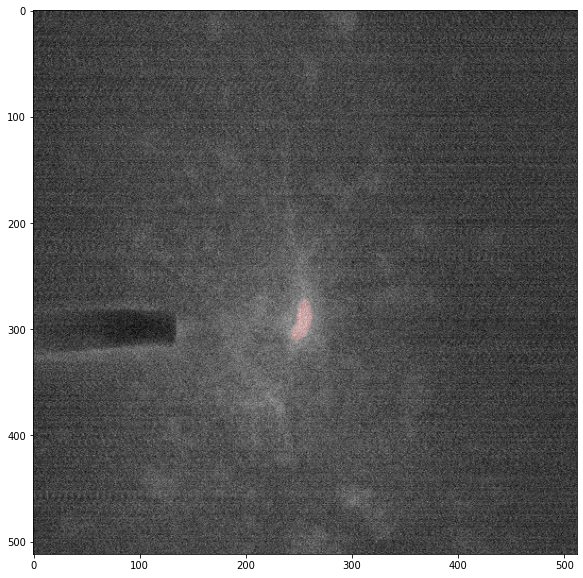

In [259]:
if VERBOSE:
    show_image = np.sum(img_clahe, axis=0)
    imgplot = plt.imshow(show_image)
    plt.imshow(np.sum(obj.soma_mask, axis=0), cmap=cmap1, alpha=0.2)
    plt.show()

In [ ]:
print('Branch Segmentation')
%time obj.branch_segmentation((1,), sigmas=sigmas)

Branch Segmentation
Vectors and Masks...


Calculating::   0%|          | 0/6 [00:00<?, ?it/s]

In [235]:
print('Full Graph')
%time obj.full_graph_plotting(alpha, beta)

Full Graph


KeyboardInterrupt: 

In [ ]:
if VERBOSE:
    show_image = np.sum(img_clahe, axis=0)
    imgplot = plt.imshow(show_image)
    plt.imshow(np.sum(obj.soma_mask, axis=0), cmap='Reds', alpha=0.2)
    plt.show()

In [127]:
print('Graph')
%time obj.astro_graph_plotting(min_path_length=10)
graph = obj.graph

Graph


  0%|          | 0/614 [00:00<?, ?it/s]

<class 'astro_graph.AstroGraph'>
No cycles!
CPU times: user 25.7 s, sys: 154 ms, total: 25.9 s
Wall time: 25.9 s


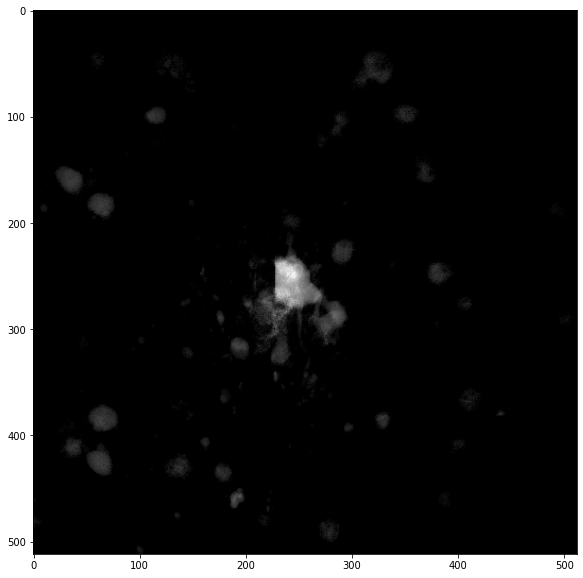

In [132]:
plt.imshow(np.sum(obj.sigma_mask, axis=0))